# occupancy prediction

![img](dev/IMG_6435.jpg)

plan:
- split `real_data_array` into `timeunit` chunks
- compute transition matrix for each chunk
- simulate `timeunit` length of data using each transition matrix
- compare simulated data to each respective real data chunk
- make sure to normalize the *`timestep`* with `scipy.signal.decimate`
<br>
<br>

In [1]:
# set autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm_notebook, tnrange, trange, tqdm
from itertools import cycle
from collections import Counter
from pathlib import Path
import time

import altair as alt
from altair.expr import datum

from _modules.wifi_traffic_analyzer import WifiTrafficAnalyzer

## params

In [3]:
timeunit = 10_000

## configs

In [4]:
real_data_path_dict = {
    'real_2': Path(r'data/wifitrafficstats2.csv'),
    'real_3': Path(r'data/wifitrafficstats3.csv'),
    'real_4': Path(r'data/wifitrafficstats4.csv'),
    'real_5': Path(r'data/wifitrafficstats5.csv'),
    'real_6': Path(r'data/wifitrafficstats6.csv')
}

transition_matrices_path_dict = {
    'tmat_1': Path(r'data/wifi_t_matrices.csv'),
    #'tmat_2': Path(r'data/wifi_t_matrices2.csv')
}

## occupancy predictor

### classing it up

In [5]:
class OccupancyPredictor:
    def __init__(self, real_data_path_dict, timeunits, autoselect_file=True):
        print('initializing OP..')
        
        # attributes
        self.real_data_path_dict = real_data_path_dict
        
        # set timeunits
        if not isinstance(timeunits, list):
            self.timeunits = [timeunits]
            print(f'single timeunit received {self.timeunits}')
        else:
            self.timeunits = timeunits
            print(f'{len(self.timeunits)} timeunits received')            
        
        # startup tasks
        self.WTA_real = WifiTrafficAnalyzer(mode='real', path_dict=self.real_data_path_dict)
        self.select_file_key(autoselect=autoselect_file)
        
        
    
    def select_file_key(self, autoselect):        
        if autoselect:
            self.file_key = list(self.WTA_real.path_dict.keys())[0]
            self.WTA_real.process_real_data(self.file_key)
            print(f'\tautoselected and processed \'{self.file_key}\'')
            
        else:
            file_key = input('please select a target file..')
            
            try:
                assert file_key.strip().lower() in self.WTA_real.path_dict.keys()
                
                self.file_key = file_key.strip().lower()
                self.WTA_real.process_real_data(self.file_key)
                
                print(f'\tset and processed target file: {self.file_key}')
                
            except AssertionError:
                print(f'invalid target file: {file_key}, options are {self.WTA_real.path_dict.keys()}')
                raise
        
        
    def convert_and_reshape(self, timeunit):
        self.data_array = self.WTA_real.real_data_array
        print(f'generated real data array, size: {self.data_array.shape}')
        
        data_matrix = (
            self.data_array[
                :int(timeunit*np.round(len(self.data_array) / timeunit))
            ].reshape((-1, timeunit))
        )
        print(f'reshaped into {data_matrix.shape[0]} : {timeunit}µs chunks')
        
        return data_matrix
    
        
    def compute_transition_matrix(self, row, timeunit):
        onon, onoff, offon, offoff = 0, 0, 0, 0
        
        for i in range(timeunit-1):    
            # if ON -> ON
            if row[i] == row[i+1] == 1:
                onon += 1
                
            # if ON -> OFF
            elif row[i] == 1 and row[i+1] == 0:
                onoff += 1
                
            # if OFF -> ON
            elif row[i] == 0 and row[i+1] == 1:
                offon += 1
                
            #if OFF -> OFF
            elif row[i] == row[i+1] == 0:
                offoff += 1
                
        try:
            p_onon = onon / (onon + onoff)
        except ZeroDivisionError:
            p_onon = 0
        
        try:
            p_offoff = offoff / (offoff + offon)
        except ZeroDivisionError:
            p_offoff = 0
            
        try:
            p_onoff = onoff / (onon + onoff)
        except ZeroDivisionError:
            p_onoff = 0
            
        try:
            p_offon = offon / (offoff + offon)
        except ZeroDivisionError:
            p_offon = 0
            
        
        return (p_onon, p_onoff, p_offon, p_offoff) 
    
    
    def compute_tmats_and_load_df(self, data_matrix, timeunit):
        # compute all transition matrices
        tmat_array = [
            self.compute_transition_matrix(
                data_matrix[idx,:],
                timeunit
            )
            for idx in tnrange(data_matrix.shape[0])
        ]
        
        # load dataframe
        tmat_df = (
            pd
            .DataFrame(
                tmat_array, 
                columns=['OnOn', 'OnOff', 'OffOn', 'OffOff']
            ).assign(
                timeunit = timeunit,
                source = self.file_key
            )
            [['OnOn','OnOff','OffOff','OffOn','timeunit','source']]
        )
        print(f'created transition matrix dataframe, {tmat_df.shape[0]} rows')
        
        return tmat_df
    
    
    def process_timeunit(self, timeunit):
        print(f'processing data for timeunit: {timeunit}µs')
        
        data_matrix = self.convert_and_reshape(timeunit)        
        tmat_df = self.compute_tmats_and_load_df(data_matrix, timeunit)
        
        return data_matrix, tmat_df
        
        

In [6]:
OP = OccupancyPredictor(real_data_path_dict, timeunit, autoselect_file=True)

initializing OP..
single timeunit received [10000]
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv



	autoselected and processed 'real_2'


In [7]:
data_matrix, tmat_df = OP.process_timeunit(OP.timeunits[0])

print(f'data matrix: {data_matrix.shape}')
display(tmat_df.head())

processing data for timeunit: 10000µs
generated real data array, size: (40431970,)
reshaped into 4043 : 10000µs chunks



created transition matrix dataframe, 4043 rows
data matrix: (4043, 10000)


,OnOn,OnOff,OffOff,OffOn,timeunit,source
0,0.923077,0.076923,1.000000,0.000000,10000,real_2
1,0.000000,0.000000,1.000000,0.000000,10000,real_2
2,0.000000,0.000000,1.000000,0.000000,10000,real_2
3,0.998675,0.001325,0.999784,0.000216,10000,real_2
4,0.999353,0.000647,1.000000,0.000000,10000,real_2


In [13]:
sim_data_matrix = OP.WTA_real.simulate_all_OP_transition_matrices(
    tmat_dataframe=tmat_df,
    n_samples=OP.timeunits[0], 
    m_trials=1
)[1:,:]

print(f'sim data matrix: {sim_data_matrix.shape}')


total elapsed time: 1.71 minutes
sim data matrix: (4043, 10000)


In [18]:
print(f'real data shape: {data_matrix.shape}')
data_matrix.sum(axis=1)[:10]

real data shape: (4043, 10000)


array([  13,    0,    0,  756, 1545, 2105,   13,    0,   65,    0])

In [19]:
print(f'sim data shape: {sim_data_matrix.shape}')
sim_data_matrix.sum(axis=1)[:10]

sim data shape: (4043, 10000)


array([4998.,    0.,    0., 5913., 4205., 6667., 5094.,    0., 4461.,
          0.])

In [23]:
comp_df = (
    pd
    .DataFrame({
        'real_data': data_matrix.sum(axis=1),
        'sim_data': sim_data_matrix.sum(axis=1)
    })
    .assign(
        real_data = lambda x: x.real_data.astype('int'),
        sim_data = lambda x: x.sim_data.astype('int')
    )
    .eval('diff = sim_data - real_data')
)

comp_df.head()

,real_data,sim_data,diff
0,13,4998,4985
1,0,0,0
2,0,0,0
3,756,5913,5157
4,1545,4205,2660


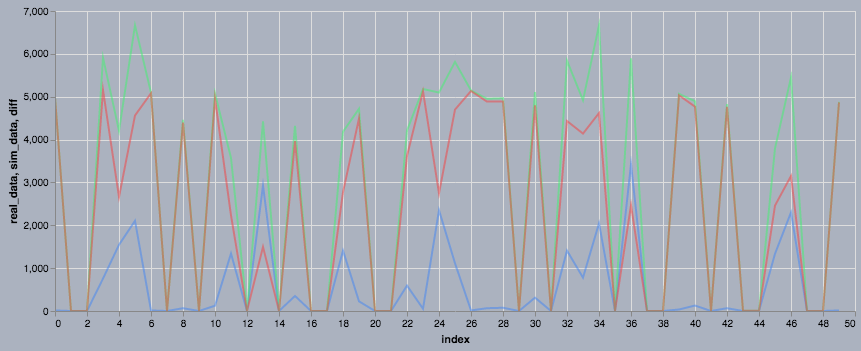

In [37]:
base = alt.Chart(
    comp_df.reset_index().iloc[:50],
    height=300,
    width=800
).mark_line(
    opacity=0.5
).encode(
    alt.X('index:Q'),
    #alt.Y('real_data:Q')
)

alt.layer(
    base.encode(
        alt.Y('real_data:Q'),
        color=alt.value('#4286f4') # blue
    ),
    base.encode(
        alt.Y('sim_data:Q'),
        color=alt.value('#41f470') # green
    ),
    base.encode(
        alt.Y('diff:Q'),
        color=alt.value('#f44141') # red
    ),
    background='#abb2bf'
).interactive()

In [39]:
comp_df.corr()

,real_data,sim_data,diff
real_data,1.000000,0.552440,0.215014
sim_data,0.552440,1.000000,0.932839
diff,0.215014,0.932839,1.000000


In [38]:
comp_df.head(50)

,real_data,sim_data,diff
0,13,4998,4985
1,0,0,0
2,0,0,0
3,756,5913,5157
4,1545,4205,2660
5,2105,6667,4562
6,13,5094,5081
7,0,0,0
8,65,4461,4396
9,0,0,0


### scipy testing

## misfits